In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

/home/gj/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/gj/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
tf.__version__

'2.0.0-beta0'

In [3]:
@tf.function
def distance_matrix(pos_vector):
    r = tf.reduce_sum(pos_vector*pos_vector, 1)
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(pos_vector, tf.transpose(pos_vector)) + tf.transpose(r)
    return tf.sqrt(D)

@tf.function
def potential_field(m_vector, pos_vector):

    num_particles = m_vector.shape[0]
    mask = tf.reshape(tf.range(num_particles),(1,-1) ) < tf.reshape(tf.range(num_particles), (-1,1))

    dist = tf.boolean_mask(distance_matrix(pos_vector), mask)
    masses =  tf.boolean_mask(tf.tensordot(m_vector, m_vector, axes = 0), mask)
    
    return -1 * tf.reduce_sum(masses/dist)
    
    

In [7]:
@tf.function
def step(pos_vector, vel_vector, step_size = 1e-5, number_of_steps = 1000):
    
    for i in tf.range(number_of_steps):

        with tf.GradientTape() as tape:
            tape.watch(pos_vector)
            V = potential_field(m_vector,pos_vector)

        grad = tape.gradient(V, pos_vector)

        acceleration = -1* grad/tf.expand_dims(m_vector, axis = 1)   



        pos_vector = pos_vector + step_size*vel_vector
        vel_vector = vel_vector + step_size*acceleration
    
    return pos_vector, vel_vector
    

In [14]:
m_vector = tf.constant(np.array([50., 10., 1.]), dtype= tf.float64)
pos_vector = tf.Variable(np.array([[0, 0], [0, 100], [0, -50]]), dtype= tf.float64)
vel_vector = tf.Variable(np.array([[0, 0], [-100, 0], [100, 0]]), dtype= tf.float64)

path = [pos_vector.numpy()]


In [15]:

for i in tqdm.trange(1000):

    pos_vector, vel_vector = step(pos_vector, vel_vector)
    path.append(pos_vector.numpy())
        
 





 15%|█▌        | 152/1000 [00:29<02:45,  5.11it/s]


 30%|███       | 303/1000 [00:59<02:15,  5.16it/s]


 45%|████▌     | 454/1000 [01:28<01:46,  5.14it/s]


 60%|██████    | 605/1000 [01:57<01:16,  5.15it/s]


 76%|███████▌  | 756/1000 [02:27<00:47,  5.15it/s]


 91%|█████████ | 907/1000 [02:56<00:18,  5.13it/s]


100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


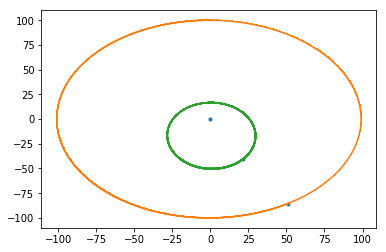

In [16]:
to_plot = np.stack(path)
plt.plot(to_plot[:,:,0], to_plot[:,:,1], marker = ',')
plt.scatter(to_plot[-1,:,0], to_plot[-1,:,1], marker = '.')
plt.show()